In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from data.dataset import Observation

In [2]:
num_entries = 20000
X_MIN = -4
X_MAX = 4
NUM_DIMS = 2

In [3]:
def prob_func(x: list[float]) -> np.ndarray:
    top = abs(np.sum([(abs(X_MIN)+1)*(abs(X_MAX)+1) for dim in x]))
    p0 = abs(np.sum([(dim+1)*(dim+1) for dim in x]))/top
    p = [p0, 1-p0]
    p /= sum(p)
    return p

def val_func(x: list[float]) -> np.ndarray:
    # returns array of y values. each y value is a function f(y_i) = (x_1, ..., x_n)
    val = float(np.random.choice([0,1], size=1, p=prob_func(x)))
    return val
    # val = np.array([(dim+1)*(dim+1) for dim in x])
    # return np.mean(val)

def prob_2_func(x: list[float]) -> np.ndarray:
    top = abs(np.sum([(abs(X_MIN)+1)*(abs(X_MAX)+1) for dim in x]))
    p0 = abs(np.sum([(dim-1)*(dim-1) for dim in x]))/top
    p = [p0, 1-p0]
    p /= sum(p)
    return p

def val_2_func(x: list[float]) -> np.ndarray:
    # returns array of y values. each y value is a function f(y_i) = (x_1, ..., x_n)
    val = float(np.random.choice([0,1], size=1, p=prob_2_func(x)))
    return val
    # val = np.array([(dim+1)*(dim+1) for dim in x])
    # return np.mean(val)



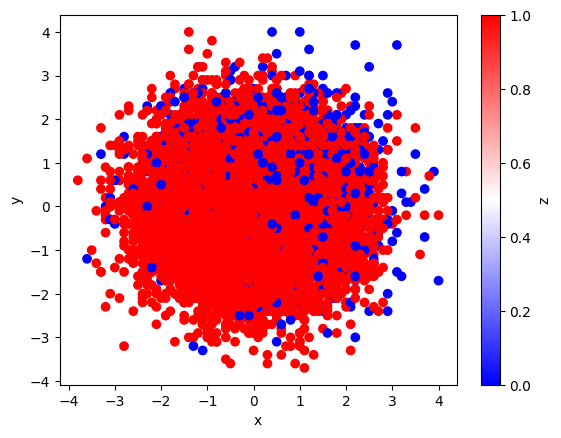

In [4]:
NUM_LABELS = 2
data_x = np.ndarray(shape=(int(num_entries), NUM_DIMS))
data_x[:,0] = np.around(np.random.normal(0, 1, num_entries), decimals=1)
data_x[:,1] = np.around(np.random.normal(0, 1, num_entries), decimals=1)
# data_x[:,2] = np.around(np.random.normal(0, 1, num_entries), decimals=1)
# data_x_1 = np.ndarray(shape=(int(num_entries/2), NUM_DIMS))
# data_x_2 = np.ndarray(shape=(int(num_entries/2), NUM_DIMS))
# data_x_1[:,0] = np.around(np.random.normal(-2,0.6,int(num_entries/2)), decimals=1)
# data_x_1[:,1] = np.around(np.random.normal(-1,0.6,int(num_entries/2)), decimals=1)
# data_x_1[:,2] = np.around(np.random.triangular(-4,-1,4,int(num_entries/2)), decimals=1)
# data_x_2[:,0] = np.around(np.random.normal(2, 0.6, int(num_entries/2)), decimals=1)
# data_x_2[:,1] = np.around(np.random.normal(2, 0.6, int(num_entries/2)), decimals=1)
# data_x_2[:,2] = np.around(np.random.triangular(-4,3,4,int(num_entries/2)), decimals=1)
# data_x = np.concatenate((data_x_1, data_x_2), axis=0)
data_x = np.where(data_x > X_MAX, np.full(data_x.shape, X_MAX), data_x)
data_x = np.where(data_x < X_MIN, np.full(data_x.shape, X_MIN), data_x)
data_y = np.ndarray(shape=(num_entries, NUM_LABELS))
data_y[:, 0] = [val_func(x) for x in data_x]
data_y[:, 1] = [val_2_func(x) for x in data_x]

def plot(data_x, data_y, cmap = "gist_rainbow"):
    fig, ax = plt.subplots()
    scat = ax.scatter(x=data_x[:,0], y=data_x[:,1], c=data_y[:, 0], cmap=cmap)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(scat, ax=ax, label='z')
plot(data_x=data_x, data_y=data_y, cmap="bwr")

In [5]:
def aggregate_by(data_y: torch.tensor, meta: list[Observation]):
    def get_entries(indices):
        return torch.index_select(data_y, 0, torch.tensor(indices))

    def aggregate(entries: torch.tensor):
        return entries.mean(axis=0)

    obs_y = torch.stack([aggregate(get_entries(obs.entries_indices)) for obs in meta]).float()
    return obs_y


In [6]:
def generate_independent_observations(data_y: torch.tensor, num_observations: int) -> list[
    torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    entry_no = len(data_y)
    meta = np.linspace(0, entry_no, entry_no, endpoint=False, dtype=int)
    np.random.shuffle(meta)
    meta = np.array_split(meta, num_observations)
    meta = [Observation(x, i) for i, x in enumerate(meta)]

    obs_y = aggregate_by(data_y, meta)
    return [obs_y, meta]

In [7]:
def generate_dependent_observations(data_x: torch.tensor, data_y: torch.tensor, num_observations: int, dims:list[int]) -> list[torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    meta = np.linspace(X_MIN, X_MAX, abs(X_MAX - X_MIN) * 10 + 1, endpoint=True, dtype=float)

    aggregation_masks = [torch.ones(num_entries, dtype=torch.bool)]
    for dim in dims:
        new_aggregation_masks = []
        for mask in aggregation_masks:
            for prev, curr in zip(meta, meta[1:]):
                dim_mask = torch.logical_and((data_x[:, dim] <= curr), (data_x[:, dim] >= prev))
                aggregation_mask = torch.logical_and(dim_mask, mask)
                new_aggregation_masks.append(aggregation_mask)
            aggregation_masks = new_aggregation_masks
    aggregation_indices = [mask.nonzero(as_tuple=True)[0] for mask in aggregation_masks]
    meta = [indices.numpy().tolist() for indices in aggregation_indices if indices.numel() > 0]
    # meta = [torch.logical_and((data_x[:, dims] <= curr), (data_x[:, dims] >= prev)).nonzero(as_tuple=True)[0] for prev, curr in
    #         zip(meta, meta[1:])]
    # meta = [obs.numpy().tolist() for obs in meta if obs.size(dim=0)]
    meta = [Observation(x, i) for i, x in enumerate(meta)]

    obs_y = aggregate_by(data_y, meta)

    return [obs_y, meta]

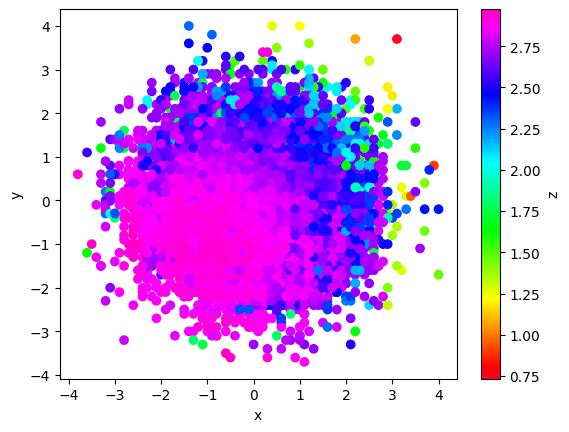

In [8]:
import itertools
def get_data_y(data_x, data_y, dims: list[int], num_observations=10):
    data_x = torch.tensor(data_x)
    data_y = torch.tensor(data_y)
    obs_y, meta = generate_dependent_observations(data_x, data_y, num_observations=num_observations, dims=dims)
    for obs in meta:
        for index in obs.entries_indices:
            data_y[index] = obs_y[obs.value_vec_index]
    return data_y.numpy()
test_y = np.zeros(np.array(data_y).shape)
for dim in range(NUM_DIMS):
    test_y += get_data_y(data_x, data_y, [dim])
for dim_ab in list(itertools.combinations(range(NUM_DIMS), 2)):
    test_y += get_data_y(data_x, data_y, list(dim_ab))
plot(data_x=data_x, data_y=test_y)

In [9]:
import pandas as pd

labels = ["clicks", "sales"]
allfeatures = ["attr_" + str(i) for i in range(0,NUM_DIMS)]


def aggregate_on_features(features, mincount, data):
    df = data[labels + features]
    df["c"] = 1
    df = df.groupby(features).sum().reset_index()
    df = df[df.c > mincount].copy()
    return df

def aggregate_on_all_pairs(
    allfeatures,
    data,
    mincount=0,
    gaussian_sigma=None,
):
    allpairsdf = pd.DataFrame()
    for f0 in allfeatures:
        feature_1_id = int(f0.split("_")[-1])
        for f1 in allfeatures:
            feature_2_id = int(f1.split("_")[-1])
            if not feature_1_id < feature_2_id:
                continue
            print("aggregating on", f0, f1)
            features = [f0, f1]
            df = aggregate_on_features(features, mincount, data)
            df["feature_1_id"] = feature_1_id
            df["feature_2_id"] = feature_2_id
            df = df.rename(
                {
                    features[0]: "feature_1_value",
                    features[1]: "feature_2_value",
                },
                axis=1,
            )
            allpairsdf = pd.concat([allpairsdf, df])
    if gaussian_sigma is not None:
        allpairsdf["c"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["clicks"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["sales"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
    return allpairsdf

def aggregate_on_all_single(
    allfeatures, data, mincount=0, gaussian_sigma=None
):
    allpairsdf = pd.DataFrame()
    for f0 in allfeatures:
        print("aggregating on", f0)

        features = [f0]
        df = aggregate_on_features(features, mincount, data)
        df["feature_1_id"] = int(f0.split("_")[-1])
        df = df.rename({features[0]: "feature_1_value"}, axis=1)
        allpairsdf = pd.concat([allpairsdf, df])
    if gaussian_sigma is not None:
        allpairsdf["c"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["clicks"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["sales"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
    return allpairsdf

data = pd.DataFrame()
for i, f in enumerate(allfeatures):
    data[f] = np.array(data_x)[:, i]
for i, l in enumerate(labels):
    data[l] = np.array(data_y).reshape((len(data_y), len(labels)))[:, i]
gaussian_sigma = 0.3
aggregates_single = aggregate_on_all_single(allfeatures, data=data, gaussian_sigma=gaussian_sigma)
aggregates_pairs = aggregate_on_all_pairs(allfeatures, data=data, mincount=4, gaussian_sigma=gaussian_sigma)

aggregating on attr_0
aggregating on attr_1
aggregating on attr_0 attr_1


C:\Users\Zerafoth\AppData\Local\Temp\ipykernel_45060\1537963778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c"] = 1


In [10]:
aggregates_pairs

,feature_1_value,feature_2_value,clicks,sales,c,feature_1_id,feature_2_id
152,-2.3,-0.5,5.144018,2.860440,4.893224,0,1
157,-2.3,0.0,5.422742,6.320783,5.550978,0,1
158,-2.3,0.1,5.348508,3.962877,5.389472,0,1
162,-2.3,0.5,5.353511,4.122625,4.628954,0,1
216,-2.1,-0.4,5.127000,3.910389,4.757732,0,1
...,...,...,...,...,...,...,...
2302,2.1,0.6,3.959560,3.719850,4.682187,0,1
2303,2.1,0.7,3.815803,4.738928,4.651645,0,1
2325,2.2,-0.9,4.226180,4.114286,4.979542,0,1
2337,2.2,0.3,1.178659,4.107495,5.093403,0,1


In [11]:
NORMALIZE = True
FILTER = True
if FILTER:
    aggregates_pairs = aggregates_pairs[(aggregates_pairs.c > 1) & (aggregates_pairs.clicks > 0) & (aggregates_pairs.sales > 0)]
if NORMALIZE:
    aggregates_pairs = aggregates_pairs.assign(zeros = 0)
    aggregates_pairs.c = aggregates_pairs[['clicks', 'sales', 'c', 'zeros']].max(axis=1)
    aggregates_pairs.clicks = aggregates_pairs[['clicks', 'zeros']].max(axis=1)
    aggregates_pairs.sales = aggregates_pairs[['sales', 'zeros']].max(axis=1)
    aggregates_pairs = aggregates_pairs.drop(['zeros'], axis=1)

    aggregates_single = aggregates_single.assign(zeros = 0)
    aggregates_single.c = aggregates_single[['clicks','sales','c','zeros']].max(axis=1)
    aggregates_single.clicks = aggregates_single[['clicks', 'zeros']].max(axis=1)
    aggregates_single.sales = aggregates_single[['sales', 'zeros']].max(axis=1)
    aggregates_single = aggregates_single.drop(['zeros'], axis=1)

aggregates_pairs
# aggregates_single

,feature_1_value,feature_2_value,clicks,sales,c,feature_1_id,feature_2_id
152,-2.3,-0.5,5.144018,2.860440,5.144018,0,1
157,-2.3,0.0,5.422742,6.320783,6.320783,0,1
158,-2.3,0.1,5.348508,3.962877,5.389472,0,1
162,-2.3,0.5,5.353511,4.122625,5.353511,0,1
216,-2.1,-0.4,5.127000,3.910389,5.127000,0,1
...,...,...,...,...,...,...,...
2302,2.1,0.6,3.959560,3.719850,4.682187,0,1
2303,2.1,0.7,3.815803,4.738928,4.738928,0,1
2325,2.2,-0.9,4.226180,4.114286,4.979542,0,1
2337,2.2,0.3,1.178659,4.107495,5.093403,0,1


In [12]:
import networkx as nx
from statistics import mean
class TestDataGraph(nx.DiGraph):
    def __init__(self):
        super().__init__(self)

    @staticmethod
    def probability(individual_count: int, sum_count: float, mean_count: float, no_objects: int):
        return (np.float64(individual_count) + np.float64(mean_count)) / (
                np.float64(sum_count) + (np.float64(no_objects) * np.float64(mean_count)))

    def get_probabilities_for(self, objects, from_objects=None):
        if from_objects is None:
            from_objects = objects
        objects_counts = [float(from_objects[obj]["count"]) for obj in objects]
        sum_count = sum(objects_counts)
        mean_count = mean(objects_counts)
        return np.array(
            [self.probability(individual_count, sum_count, mean_count, len(objects_counts)) for individual_count in
             objects_counts])

    def remove_unreachable_nodes(self):
        to_delete = []
        for node in tqdm(self.nodes(), total=self.number_of_nodes(), desc="Removing unreachable nodes"):
            node_edges = self.edges(node)
            if len(node_edges) == 0:
                to_delete.append(node)
        for node in to_delete:
            self.remove_node(node)
        del to_delete

    def assign_probabilities(self):
        node_probabilities = {}
        edge_probabilities = {}
        nprobs = self.get_probabilities_for(self.nodes())
        for node, prob in tqdm(zip(self.nodes(), nprobs), total=self.number_of_nodes(), desc="Assigning probabilities"):
            node_probabilities[node] = prob
            edge_probs = self.get_probabilities_for(self.edges(node), self.edges())
            for edge, eprob in zip(self.edges(node), edge_probs):
                edge_probabilities[edge] = eprob
        del nprobs
        nx.set_node_attributes(self, node_probabilities, name="prob")
        del node_probabilities
        nx.set_edge_attributes(self, edge_probabilities, name="prob")
        del edge_probabilities

    def create_nodes(self, data_singles):
        for entry in data_singles:
            feature_value, clicks, sales, count, feature_id = entry
            node = f"attr_{int(feature_id)}_val_{feature_value}"
            self.add_node(node, count=float(count), clicks=float(clicks), sales=float(sales))

    def create_edges(self, data_pairs):
        for entry in data_pairs:
            feature_1_value, feature_2_value, clicks, sales, count, feature_1_id, feature_2_id = entry
            node_a = f"attr_{int(feature_1_id)}_val_{feature_1_value}"
            node_b = f"attr_{int(feature_2_id)}_val_{feature_2_value}"
            self.add_edge(node_a, node_b, count=float(count), clicks=float(clicks), sales=float(sales))
            self.add_edge(node_b, node_a, count=float(count), clicks=float(clicks), sales=float(sales))

    def prep(self, data_singles, data_pairs):
        self.create_nodes(data_singles)
        self.create_edges(data_pairs)
        self.remove_unreachable_nodes()
        self.assign_probabilities()

In [13]:
from data.data_generator import DataGenerator
from data.ctr_normalize import CTRNormalize
from tqdm import tqdm

data_graph = TestDataGraph()
data_graph.prep(data_singles=aggregates_single.to_numpy(), data_pairs=aggregates_pairs.to_numpy())
DG = DataGenerator(data_graph=data_graph, ctr_normalize=CTRNormalize.no_action, no_attributes=len(allfeatures))


Assigning probabilities: 100%|██████████| 94/94 [00:00<00:00, 6715.23it/s]


In [14]:
DG.generate_entry()

(array([ 0.6, -1.2]), array([0.94808402, 0.89290046]))

100%|██████████| 20000/20000 [00:07<00:00, 2684.37it/s]


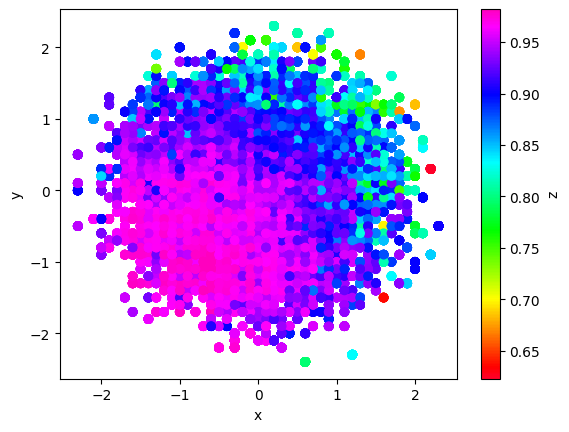

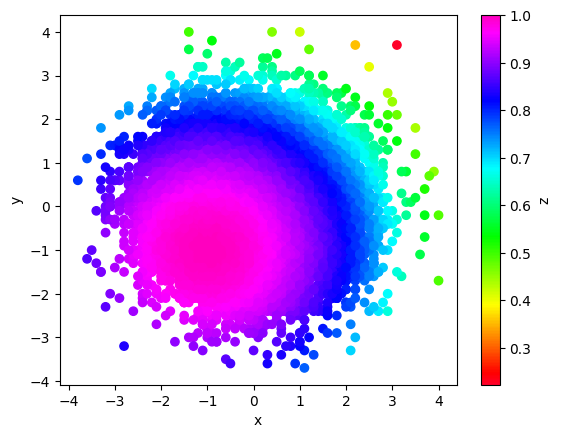

In [15]:
data_yp = [[prob_func(x)[1], prob_2_func(x)[1]] for x in data_x]
gen_data_x = []
gen_data_y = []
for i in tqdm(range(num_entries)):
    x, y = DG.generate_entry()
    gen_data_x.append([float(entry) for entry in x])
    gen_data_y.append([float(entry) for entry in y])
plot(data_x=np.array(gen_data_x), data_y=np.array(gen_data_y))
plot(data_x=np.array(data_x), data_y=np.array(data_yp))

In [16]:
# import os
# data_gen_dest = os.getcwd() + "/datasets/criteo/prepared/generated.csv"
# DG.generate_data(1000, filename=data_gen_dest, force=True)